In [98]:
import math
import requests
import json

def get_price(vm_size_name: str) -> float:
    url = f"https://prices.azure.com/api/retail/prices?$filter=serviceName eq 'Virtual Machines' and location eq 'US West 2' and armSkuName eq '{vm_size_name}'"
    for entry in json.loads(requests.get(url).text)["Items"]:
        if entry["type"] == "Consumption" and "Windows" not in entry["productName"] and not "Low Priority" in entry["meterName"] and not "Spot" in entry["meterName"]:
            return entry["unitPrice"] * 24 * 365 / 12
    raise Exception(f"Price not found for: {vm_size_name}")

# Azure vm costs per their calculator
azure_compute = {
    "B4ms":   { "monthly_price": get_price("Standard_B4ms"), "cpus": 4 },
    "D4s_v4": { "monthly_price": get_price("Standard_D4s_v4"), "cpus": 4 },
    "D2s_v5": { "monthly_price": get_price("Standard_D2s_v5"),  "cpus": 2 },
    "B16ms":  { "monthly_price": get_price("Standard_B16ms"), "cpus": 16 },
}

print("Monthly Prices:")
print(f"B16ms: {azure_compute['B16ms']}")
print(f"D2s_v5: {azure_compute['D2s_v5']}")


# Each user gets their own managed disk
managed_os_disk_price_per_month = 0.30

# Months in a school term
term_months = 3

# Hours in a week
hours_in_a_week = 168

# Weeks in a month
weeks_in_a_month = 4.125

Monthly Prices:
B16ms: {'monthly_price': 486.18000000000006, 'cpus': 16}
D2s_v5: {'monthly_price': 70.08000000000001, 'cpus': 2}


---

<img src="https://jupyter.org/assets/homepage/hublogo.svg" alt="hublogo" width="400"/>

# Jupyterhub Costs Calculation

This notebook can be used to calculate the costs associated with running Jupyterhub in several configurations.

You can modify the values below to adjust the end prices.

#### Target Cost per Student per Term

In [53]:
target_cost_per_student = 50

#### Estimated Students per Class

In [54]:
students_per_class = 250

#### Resource Allocation Multiplier

This value is used to calculate how much resources are allocated for each student. A value of 1.0 means that each student is guaranteed to have 1cpu and 4gb memory. Increasing this value to 2.0 would double the resources, giving them 2cpu/8gb. Similarly, decreasing it to 0.5 would guarantee them at .5cpu/2gb.

In [55]:
res_alloc_mult = 1.0

#### Miscellaneous Costs for Azure Components

There are other components needed for a Jupyterhub cluster, such as a Public IP and Container Registry. This number can be adjusted to account for those costs.

In [56]:
azure_misc_monthly_cost = 150

#### Persistent Storage Volumes for Student Data

The estimated cost for 4GB of persistent volume storage for student data.

In [57]:
student_storage_monthly_cost = 4

### Required CPU Count for the Cluster

Given the information above, we can base our cluster size on the number of CPUs required to handle all the students.

In [58]:
required_cpus = math.ceil(students_per_class * res_alloc_mult)
print(f"Required number of CPUs: {required_cpus}")

Required number of CPUs: 250


---

# Virtual Machine Cluster - Azure

This scenario is similar to how we currently have our jupyterhub cluster set up on-prem.

Uses standard Virtual Machines that are always on and is *not scalable*. We can use with B-series systems (cheaper, less performant), or D4-series (enterprise performance). I've chosen the cheaper system, as these machines will not be seeing sustained heavy use.

We also factor in the other costs such as the misc azure costs stated above, as well as the cost for persistent student data storage volumes.

## Cost Evaluation

Virtual Machine size

In [59]:
vm_size = "B4ms"

Grab the price for that virtual machine size and the number of CPUs it provides.

In [60]:
vm_price = azure_compute[vm_size]["monthly_price"]
vm_cpus = azure_compute[vm_size]["cpus"]

Based on the number of CPUs, we can calculate how many nodes we'll need to support the student count.

In [61]:
num_nodes = math.ceil(required_cpus / vm_cpus)

Next we find the monthly cost for the whole cluster, including the miscellaneous azure costs and student storage.

In [62]:
azure_vm_cluster_monthly_cost = \
    (num_nodes * vm_price) + azure_misc_monthly_cost + (students_per_class * student_storage_monthly_cost)

Finally, we can calculate the cluster cost per term.

In [63]:
azure_vm_cluster_term_cost = azure_vm_cluster_monthly_cost * (term_months + 1)

Then break it down into student cost per term.

In [64]:
azure_vm_cluster_term_cost_per_student = \
    azure_vm_cluster_term_cost / students_per_class

## Results

In [65]:
print(f"Cost for cluster per term: ${azure_vm_cluster_term_cost:,.2f}")
print(f"Cost per student per term: ${azure_vm_cluster_term_cost_per_student:,.2f}")

Cost for cluster per term: $35,137.36
Cost per student per term: $140.55


---

# Virtual Machine Cluster - On-Prem

This is our current environment. Exactly the same as above, but our on-prem costs are estimated to be **one-third of azure costs**, and we don't charge for student storage. We also use higher quality Virtual Machines, compared to the B-series.

## Cost Evaluation

In [66]:
on_prem_vm_cluster_term_cost = azure_vm_cluster_term_cost * .3
on_prem_vm_cluster_term_cost_per_student = on_prem_vm_cluster_term_cost / students_per_class

## Results

In [67]:
print(f"Cost for cluster per term: ${on_prem_vm_cluster_term_cost:,.2f}")
print(f"Cost per student per term: ${on_prem_vm_cluster_term_cost_per_student:,.2f}")

Cost for cluster per term: $10,541.21
Cost per student per term: $42.16


---

# Kubernetes Cluster - Azure

This is a much more complicated environment, but may lead to the most cost savings if on-prem is to be avoided.

This cluster is configured using the [Zero to Jupyterhub](https://zero-to-jupyterhub.readthedocs.io/en/latest/) guide for hosting Jupyterhub on Kubernetes, using Azure Kubernetes Service (AKS).

Some benefits include:

- Much smaller footprint when not in use
- Autoscaling pods to reduce cluster size after class
- Creating a new cluster is much faster

Possible concerns:

- New-ish technology with no *official* support
- Managed very differently from our traditional toolset
- Staff proficiency in container management platforms


## Configuration

The AKS cluster is configured with two pools, the controller pool and the user pool. Each pool is a scaling set of pods (nodes). The Controller pool is static, while the User pool scales to meet demand.

### Node sizing

#### Controller pool

- Azure VM Size: D2s-v5
    - This size provides production-level performance for the core components of the cluster
- Only one pod needed at this moment, might need to scale this up depending on performance in production
- Scaling up to meet demand is possible, but not likely needed
- Static Cost

In [68]:
aks_controller_size = "D2s_v5"
num_controllers = 1

#### User pool

- Azure VM Size: B16ms
    - Huge (16cpu/64gb) systems to minimize scale events, using the cheaper B-series VMs.
- One pod needed at all times
- Scaling up to meet demand happens frequently
- Scaling down after demand falls below threshold is automatic
- Dynamic Cost

In [69]:
aks_userpod_size = "B16ms"
aks_userpod_cpus = azure_compute[aks_userpod_size]["cpus"]
minimum_pods = 1

### Availability

With the auto-scaling nature of this cluster, calculating costs is more involved, as we need to use hourly costs compared against lab and lecture schedule, while also accounting for minimizing scale events during homework time. The calculations below will be a best-effort estimate based on the following schedule:

Full capacity: 

- Tue: 1.5hr lecture
- Thu: 1.5hr lecture
- Fri: 12hr labs

Half capacity the rest of the time, with more down-tuning available as we see fit.

In [70]:
class_sessions_per_week = 3
class_hours = 15

In addition to the total full capacity hours, we also need to account for scaling time. 

We expect instructors will trigger a scale event some time prior to class to ensure that the cluster is at full capacity prior to students logging in.

In [71]:
before_class_scale_hours = 1

Likewise, the auto-scaler will take some time after class is over to start scaling back down. 

We will need to tune this number as it relates to how often the cluster culls inactive processes. We will need to work with instructors for this number, as I expect that it will need to change depending on the difficulty of the class (students running longer processes).

In [72]:
after_class_scale_hours = 1

Using all these values, we can calculate how many full capacity hours and half capacity hours needed.

In [73]:
full_capacity_hours_per_week = (before_class_scale_hours + after_class_scale_hours * class_sessions_per_week) + class_hours
half_capacity_hours_per_week = hours_in_a_week - full_capacity_hours_per_week
print(f"Full capacity hours per week: {full_capacity_hours_per_week}")
print(f"Half capacity hours per week: {half_capacity_hours_per_week}")

Full capacity hours per week: 19
Half capacity hours per week: 149


## Cost Evaluation

### User Storage

Each user pod needs its own storage volume to hold user data. 

We multiply the number of students by the base 4GB disk cost to get our montly user storage cost, then multiply that by the months in a term (plus an extra for file recovery) to get the full cost for the term.

In [88]:
user_storage_cost = managed_os_disk_price_per_month * students_per_class * (term_months + 1)
print(f"Monthly User Storage Cost: {user_storage_cost:.2f}")

Monthly User Storage Cost: 300.00


Each user pool node needs a managed disk. The deployment configures the size of these as 128GB (about $5/mo)

In [75]:
node_storage_cost_per_vm = 5.89

### Controller Pool

The three pods in this pool are always on, so it's easy to know the cost.

Grab the monthly price multiple by the number of controller pods.

In [76]:
aks_controller_price = azure_compute[aks_controller_size]["monthly_price"] + node_storage_cost_per_vm
aks_controller_monthly_cost = aks_controller_price * num_controllers
print(f"Term cost for just the controller(s): ${term_months * aks_controller_monthly_cost:,.2f}")

Term cost for just the controller(s): $227.91


### User Pool

Using the capacity hours calculated above, we can apply that to the pricing for AKS.

First, let's establish the base monthly cost as the user storage costs, controller costs, and miscellaneous costs.

In [77]:
aks_base_monthly_cost = user_storage_cost + aks_controller_monthly_cost + azure_misc_monthly_cost
print(f"Azure Base Monthly Cost: {aks_base_monthly_cost}")

Azure Base Monthly Cost: 525.97


We need to calculate the hourly cost for each user pod.

In [86]:
aks_userpod_hourly_cost = (
    azure_compute[aks_userpod_size]["monthly_price"]
    + node_storage_cost_per_vm
) / 30 / 24

Now we need to determine how many user pods we need at half and full capacity.

In [89]:
aks_userpod_fc_count = math.ceil(required_cpus / aks_userpod_cpus)
aks_userpod_hc_count = math.ceil(aks_userpod_fc_count / 2)
print(f"Full capacity number of nodes: {aks_userpod_fc_count}")
print(f"Half capacity number of nodes: {aks_userpod_hc_count}")

Full capacity number of nodes: 16
Half capacity number of nodes: 8


Using our capacity hours from above, we can now estimate the monthly cost for the user pods.

In [100]:
full_capacity_cost_per_week = full_capacity_hours_per_week * aks_userpod_fc_count * aks_userpod_hourly_cost
full_capacity_cost_per_month = full_capacity_cost_per_week * weeks_in_a_month
half_capacity_cost_per_week = half_capacity_hours_per_week * aks_userpod_hc_count * aks_userpod_hourly_cost
half_capacity_cost_per_month = half_capacity_cost_per_week * weeks_in_a_month

print(f"Monthly cost for Full Capacity: {full_capacity_cost_per_month:.2f}")
print(f"Monthly cost for Half Capacity: {half_capacity_cost_per_month:.2f}")

aks_userpod_monthly_cost = full_capacity_cost_per_month + half_capacity_cost_per_month
    
print(f"Azure User Pool Monthly Cost: {aks_userpod_monthly_cost:.2f}")

Monthly cost for Full Capacity: 857.02
Monthly cost for Half Capacity: 3360.43
Azure User Pool Monthly Cost: 4217.45


We can then add that to the base monthly cost to get the total monthly cost.

In [106]:
aks_total_monthly_cost = aks_base_monthly_cost + aks_userpod_monthly_cost
print(f"Monthly Total Cost: {aks_total_monthly_cost:.2f}")

Monthly Total Cost: 4743.42


We multiply by the months in a term to get the term price.

In [110]:
aks_total_term_cost = aks_total_monthly_cost * term_months
print(f"Term Cost: {aks_total_term_cost:,.2f}")

Term Cost: 14,230.26


Then we can get the cost per student.

In [109]:
aks_cost_per_student_per_term = \
    aks_total_term_cost / students_per_class

## Results

In [104]:
print(f"Cost for cluster per term: ${aks_total_term_cost:,.2f}")
print(f"Cost per student per term: ${aks_cost_per_student_per_term:,.2f}")

Cost for cluster per term: $14,230.26
Cost per student per term: $56.92


# Summary

Using the data above, we can get a nice view of the costs associated with each solution.

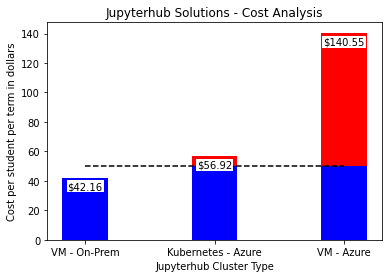

In [105]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

costs = {
    "VM - Azure": azure_vm_cluster_term_cost_per_student, 
    "VM - On-Prem": on_prem_vm_cluster_term_cost_per_student, 
    "Kubernetes - Azure": aks_cost_per_student_per_term,
}
costs = dict(sorted(costs.items(), key=lambda x:x[1]))

values = np.array(list(costs.values()))
x = range(len(values))
above_threshold = np.maximum(values - target_cost_per_student, 0)
below_threshold = np.minimum(values, target_cost_per_student)

fig, ax = plt.subplots()
ax.bar(x, below_threshold, 0.35, color="b")
ax.bar(x, above_threshold, 0.35, color="r",
        bottom=below_threshold)
plt.xticks(range(len(values)), list(costs.keys()))
ax.plot([0, 2], [target_cost_per_student, target_cost_per_student], "k--")
for i in range(len(costs)):
    plt.text(i,values[i]-8,f"${values[i]:.2f}", bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1}, ha='center')
plt.ylabel('Cost per student per term in dollars')
plt.xlabel('Jupyterhub Cluster Type')
plt.title('Jupyterhub Solutions - Cost Analysis')
plt.show()

# Conclusion

The cheapest in cost would be the Kubernetes cluster in Azure, followed closely by the on-prem solution, and lastly the vm-based solution in Azure.

While the two VM cluster solutions are fairly static in price, the Kubernetes cluster can be tuned for performance/cost. Currently, we're accounting for half capacity at non-critical hours. This could likely be tuned down to quarter-capacity, further reducing costs.

It's no surprise why many other universities (UW, Berkeley, Michigan State) are choosing to go the Kubernetes route, as the use-case is what Kubernetes was designed for.